In [41]:
import numpy as np
import scipy.linalg
import time

# Imaginary unit
I = 1j

# Parameters (corresponding to C++ #defines and constants)
#IN_DATA = "gs_S2_L1000_dx0.2.out"  # Placeholder for input data filename
L = 3.0  # Size of the gauge field
h_bar = 0.66
omega_lp_0 = 1473.36 / h_bar
omega_inc = 1473.5 / h_bar
glp = 0.01 / h_bar
mlp = h_bar**2 / (2.0 * 1.29)
gammalp = 0.047 / h_bar
GAUGE = -0.75
SPACE = 128  # Grid length
dx = 0.5  # Grid step
#K_T = 0.25  # Initialize K_T to avoid the UnboundLocalError

NX = int(SPACE / dx + 1)


In [75]:
# Define gauge field function
def gauge(x):
    #Compute gauge field for given position x
    if 64.0 - L <= x <= 64.0 + L:
        return GAUGE
    else:
        return 0.0

# Define potential function
def potential(x):
    #Compute potential for given position x
    if 64.0 - L  <= x <= 64.0 + L :
        return -(GAUGE**2) / (2.0 * mlp * h_bar)
    else:
        return 0.0

# Function to compute the square modulus of a complex number
def sq_mod(a):
    return np.abs(a)**2

# Fill Bogoliubov matrix function
def fill_matrix(bogo, psi, K_T):
    #Populate the Bogoliubov matrix based on the given parameters."""
    # Set boundary conditions and populate diagonal and off-diagonal elements
    for i in range(NX):
        diag_u = (omega_lp_0 + h_bar * 2.0 / (dx**2 *2.0 * mlp) 
                  + (h_bar * K_T - gauge(i * dx))**2 / (2.0 * mlp * h_bar) 
                  + 2.0 * glp * sq_mod(psi[i]) + potential(i * dx) - omega_inc 
                  - I * gammalp / 2.0)
        diag_v = (omega_lp_0 + h_bar * 2.0 / (dx**2 *2.0 * mlp) 
                  + (-h_bar * K_T - gauge(i * dx))**2 / (2.0 * mlp * h_bar) 
                  + 2.0 * glp * sq_mod(psi[i]) + potential(i * dx) - omega_inc 
                  + I * gammalp / 2.0)
        offdiag = glp * sq_mod(psi[i])

        bogo[2 * i, 2 * i] = diag_u
        bogo[2 * i + 1, 2 * i + 1] = -diag_v
        bogo[2 * i + 1, 2 * i] = -offdiag
        bogo[2 * i, 2 * i + 1] = offdiag

        # Off-diagonals for kinetic terms with boundary checks
        if  0<i<NX-1:
            bogo[2 * i, 2 * i - 2] = -h_bar / dx**2 / (2.0 * mlp)
            bogo[2 * i + 1, 2 * i - 1] = h_bar / dx**2 / (2.0 * mlp)
            bogo[2 * i, 2 * i + 2] = -h_bar / dx**2 / (2.0 * mlp)
            bogo[2 * i + 1, 2 * i + 3] = h_bar / dx**2 / (2.0 * mlp)
        if i==0:
            bogo[2*i,2*i+2] =  -h_bar / dx**2 / (2.0 * mlp)
            bogo[2*i+1,2*i+3] =h_bar / dx**2 / (2.0 * mlp)
        if i==NX-1:
            bogo[2*i,2*i-2] =  -h_bar / dx**2 / (2.0 * mlp)
            bogo[2*i+1,2*i-1] = h_bar / dx**2 / (2.0 * mlp)
            print(K_T)

# Main function
def main():
    # Prepare output files
    

    for K_T in np.arange(0, 1.01, 0.01):
        with open(f"aaa_L{L}_K{K_T}_dx{dx}.csv", "w") as out_bubb:
            pass  # Create/overwrite file
        # Initialize Bogoliubov matrix with complex zeros
        bogo = np.zeros((2 * NX, 2 * NX), dtype=np.complex128)
        
        # Initialize the wave function (psi)
        psi = np.full(NX, 4.0, dtype=np.complex128)

        # Fill the Bogoliubov matrix
        fill_matrix(bogo, psi, K_T)

        # Diagonalize the matrix
        start_time = time.time()
        EigVals, EigVecs = np.linalg.eig(bogo)
        diag_time = time.time() - start_time
        print(f"\tdiag_time = {diag_time} sec")


        # Sort eigenvalues and eigenvectors
        idx = EigVals.argsort()
        EigVals = EigVals[idx]
        EigVecs = EigVecs[:, idx]

        # Extract U and V matrices
        EigU = EigVecs[::2, :]
        EigV = EigVecs[1::2, :]

        # Normalize modes
        ModeNorm = np.zeros(2 * NX)
        for i in range(2 * NX):
            norm = np.sum(dx * (np.abs(EigU[:, i])**2 - np.abs(EigV[:, i])**2))
            ModeNorm[i] = norm
            EigU[:, i] /= np.sqrt(np.abs(norm))
            EigV[:, i] /= np.sqrt(np.abs(norm))

        # Save eigenvalues and modes
        with open(f"out_Kx{K_T}_freq.csv", "w") as out_freq, \
             open(f"out_Kx{K_T}_u.csv", "w") as outU, \
             open(f"out_Kx{K_T}_v.csv", "w") as outV:

            stable = True
            for i in range(NX //2 , 3*NX//2 ):
                #print(ModeNorm[i])
                out_freq.write(f"{EigVals[i].real}\t{EigVals[i].imag}\t{ModeNorm[i]}\n")
                if EigVals[i].imag > -gammalp:
                    stable = False
                    with open(f"aaa_L{L}_K{K_T}_dx{dx}.csv", "a") as out_bubb:
                        out_bubb.write(f"{K_T}\t{EigVals[i].imag}\t{EigVals[i].real}\t{i}\n")

            if stable:
                with open(f"aaa_L{L}_K{K_T}_dx{dx}.csv", "a") as out_bubb:
                    out_bubb.write(f"{L}\t0.0\t0.0\t0\n")

            # Print U and V modes for each X(j)
            for j in range(NX):
                outU.write(f"{j * dx}\t" + "\t".join(map(str, np.abs(EigU[j, NX // 2:3 * NX // 2]))) + "\n")
                outV.write(f"{j * dx}\t" + "\t".join(map(str, np.abs(EigV[j, NX // 2:3 * NX // 2]))) + "\n")


In [77]:

if __name__ == "__main__":
    main()

0.0
	diag_time = 0.5146129131317139 sec
0.01
	diag_time = 0.504241943359375 sec
0.02
	diag_time = 0.5069801807403564 sec
0.03
	diag_time = 0.5137321949005127 sec
0.04
	diag_time = 0.5237247943878174 sec
0.05
	diag_time = 0.5614240169525146 sec
0.06
	diag_time = 0.5109097957611084 sec
0.07
	diag_time = 0.5190238952636719 sec
0.08
	diag_time = 0.5207529067993164 sec
0.09
	diag_time = 0.5386385917663574 sec
0.1
	diag_time = 0.5200555324554443 sec
0.11
	diag_time = 0.5227234363555908 sec
0.12
	diag_time = 0.4871361255645752 sec
0.13
	diag_time = 0.5127091407775879 sec
0.14
	diag_time = 0.5081381797790527 sec
0.15
	diag_time = 0.5347638130187988 sec
0.16
	diag_time = 0.5272223949432373 sec
0.17
	diag_time = 0.51969313621521 sec
0.18
	diag_time = 0.6069178581237793 sec
0.19
	diag_time = 0.5266423225402832 sec
0.2
	diag_time = 0.5094020366668701 sec
0.21
	diag_time = 0.5087924003601074 sec
0.22
	diag_time = 0.5343112945556641 sec
0.23
	diag_time = 0.5249898433685303 sec
0.24
	diag_time = 0.52

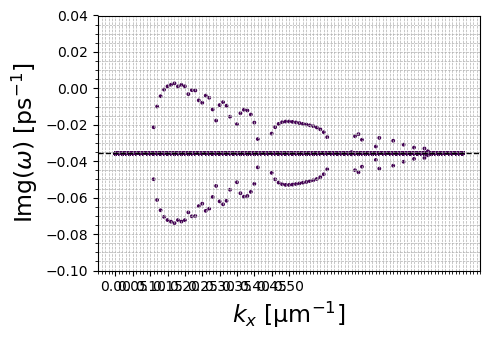

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Set up the plot
plt.figure(figsize=(5, 3.5))
plt.xlabel(r'$k_x$ [μm$^{-1}$]', fontsize=17)
plt.ylabel(r'Img($\omega$) [ps$^{-1}$]', fontsize=17)
plt.xticks(np.arange(0, 0.51, 0.05))
plt.yticks(np.arange(-0.1, 0.05, 0.02))
#plt.xlim(-0.01, 0.5)
plt.ylim(-0.1, 0.04)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

# Define color mapping (equivalent to palette in Gnuplot)
#cmap = plt.cm.get_cmap("coolwarm")

# Loop through each file that matches "out_Kx*freq.out"
files = sorted(glob.glob("out_Kx*_freq.csv"))
for i, filename in enumerate(files):
    # Extract K_T value from filename
    K_T = float(filename.split("_Kx")[1].split("_")[0])
    
    # Load data from the file, assuming columns: Real(ω), Img(ω), ModeNorm
    data = np.loadtxt(filename)
    imag_omega = data[:, 1]  # imaginary part of ω
    
    # Filter for significant values to avoid plotting erroneous points
    imag_omega = np.where(imag_omega == -0.0356061, np.nan, imag_omega)
    
    # Plot each data point for this K_T with colormap
    plt.scatter([K_T] * len(imag_omega), imag_omega, c=[K_T] * len(imag_omega), 
                 s=3)

# Reference lines similar to Gnuplot
plt.axhline(-0.0356061, color='black', linestyle='--', linewidth=1)

# Save the figure
plt.tight_layout()
plt.savefig("aaa_spectrum_SSW_img.pdf")
plt.show()


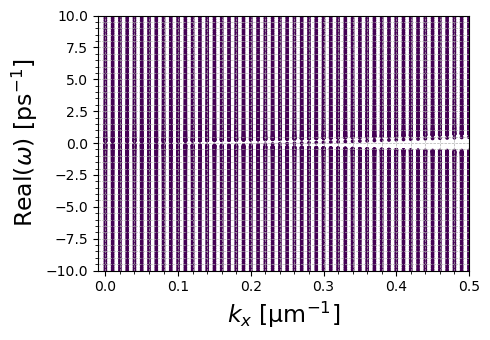

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Set up the plot
plt.figure(figsize=(5, 3.5))
plt.xlabel(r'$k_x$ [μm$^{-1}$]', fontsize=17)
plt.ylabel(r'Real($\omega$) [ps$^{-1}$]', fontsize=17)
#plt.xticks(np.arange(0, 0.51, 0.05))
#plt.yticks(np.arange(-0.1, 0.05, 0.02))
plt.xlim(-0.01, 0.5)
plt.ylim(-10, 10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

# Define color mapping (equivalent to palette in Gnuplot)
#cmap = plt.cm.get_cmap("coolwarm")

# Loop through each file that matches "out_Kx*freq.out"
files = sorted(glob.glob("out_Kx*_freq.csv"))
for i, filename in enumerate(files):
    # Extract K_T value from filename
    K_T = float(filename.split("_Kx")[1].split("_")[0])
    
    # Load data from the file, assuming columns: Real(ω), Img(ω), ModeNorm
    data = np.loadtxt(filename)
    real_omega = data[:, 0]  # imaginary part of ω
    
    
    # Plot each data point for this K_T with colormap
    plt.scatter([K_T] * len(real_omega), real_omega, c=[K_T] * len(real_omega), 
                 s=3)

# Reference lines similar to Gnuplot
#plt.axhline(-0.0356061, color='black', linestyle='--', linewidth=1)

# Save the figure
plt.tight_layout()
plt.savefig("aaa_spectrum_SSW_real.pdf")
plt.show()
